<a href="https://colab.research.google.com/github/mpmatthe/evomap-JSS/blob/main/evomap_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

This notebook replicates the paper: 'evomap - a Toolbox for Dynamic Mapping in Python'.

## Running Locally

If you want to run this notebook locally, create a virtual Python environment:

```
conda env create -n evomap-package
conda activate evomap-package
pip install evomap ipykernel
```

## Running on CoLab

To run this notebook on CoLab, select Runtime -> Run all

**Note**: The following cell needs to run twice. After running it, the session restarts. Then, run it again to confirm that the package was installed successfully. Ignore any dependency warnings.

In [ ]:
pip install evomap -U

# Setup

First, create path variabels for each subfolder and import the essential packages.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os

PATH_HOME = os.path.dirname(os.getcwd()) # parent folder
PATH_OUT = os.path.join(PATH_HOME, 'gen') # output folder

if os.path.exists(PATH_OUT):
  for file in os.listdir(PATH_OUT):
      os.remove(os.path.join(PATH_OUT, file))

# Plotting parameters
title_fontdict = {'size': 18, 'family': 'sans-serif'}
title_fontdict_large = {'size': 20, 'family': 'sans-serif'}
label_fontdict = {'size': 16, 'family': 'sans-serif'}
label_fontdict_large = {'size': 18, 'family': 'sans-serif'}

# Set random seed for reproducibility
np.random.seed(111)

# Part 1: Illustration of Static vs. Dynamic Mapping

The following code displays the necessary steps to generate the output shown in section 2 of the paper ('background on mapping').

## Loading the Data

For most of this illustration, we use a small sample from the TNIC data available through the dataset submodule.

In [3]:
from evomap.datasets import load_tnic_sample_tech

data = load_tnic_sample_tech()

The sample is organized as an edgelist where each observation corresponds to a single firm-firm pair. It contains a total of 9 firms and their pairiwse relationships over 20 years.

In [4]:
data.groupby('name1').agg({'year':'nunique'})

,year
name1,
APPLE INC,20
AT&T INC,20
EBAY INC,20
INTUIT INC,20
MICRON TECHNOLOGY INC,20
MICROSOFT CORP,20
ORACLE CORP,20
US CELLULAR CORP,20
WESTERN DIGITAL CORP,20


First, transform the edgelist into a sequence of similarity matrices

In [5]:
from evomap.preprocessing import edgelist2matrices
S_t, labels_t = edgelist2matrices(
    data,
    score_var = 'score',
    id_var_i = 'name1',
    id_var_j = 'name2',
    time_var = 'year')

The result is a sequence of matrices and a sequence of labels. As the sample is balanced, all labels remain the same over time in this example. Therefore, we simply use the first list of labels in what follows.

In [6]:
labels = labels_t[0]
labels

array(['APPLE INC', 'AT&T INC', 'EBAY INC', 'INTUIT INC',
       'MICRON TECHNOLOGY INC', 'MICROSOFT CORP', 'ORACLE CORP',
       'US CELLULAR CORP', 'WESTERN DIGITAL CORP'], dtype=object)

Preview of a single similarity matrix:

In [7]:
S_t[0].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.04, 0.  , 0.07],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  ],
       [0.  , 0.  , 0.  , 0.09, 0.  , 0.03, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.09, 0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03],
       [0.06, 0.  , 0.03, 0.05, 0.  , 0.  , 0.1 , 0.  , 0.03],
       [0.04, 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.03],
       [0.  , 0.08, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.07, 0.  , 0.  , 0.  , 0.03, 0.03, 0.03, 0.  , 0.  ]])

To map this similarity matrix via MDS, we first transform it into dissimilarities using the sim2diss function from the preprocessing submodule.

In [8]:
from evomap.preprocessing import sim2diss
D_t = []
for S in S_t:
    D_t.append(sim2diss(S, transformation = 'mirror'))

In [9]:
D_t[0].shape

(9, 9)

In [10]:
D_t[0].round(2)

array([[0.  , 1.  , 1.  , 1.  , 1.  , 0.94, 0.96, 1.  , 0.93],
       [1.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.92, 1.  ],
       [1.  , 1.  , 0.  , 0.91, 1.  , 0.97, 1.  , 1.  , 1.  ],
       [1.  , 1.  , 0.91, 0.  , 1.  , 0.95, 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 0.  , 1.  , 1.  , 1.  , 0.97],
       [0.94, 1.  , 0.97, 0.95, 1.  , 0.  , 0.9 , 1.  , 0.97],
       [0.96, 1.  , 1.  , 1.  , 1.  , 0.9 , 0.  , 1.  , 0.97],
       [1.  , 0.92, 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 1.  ],
       [0.93, 1.  , 1.  , 1.  , 0.97, 0.97, 0.97, 1.  , 0.  ]])

## Illustration of Static Mapping

Next, we create static snapshots of these matrices using MDS.

In [11]:
periods = data.year.unique()
n_periods = len(periods)
n_samples = len(labels)
D_0 = D_t[0]

In [12]:
print("First snapshot corresponds to the year {0}".format(periods[0]))

First snapshot corresponds to the year 1998


Here, we use non-metric ordinal MDS, initialized via Classical Scaling.

In [13]:
from evomap.mapping import MDS
mds = MDS(mds_type = 'ordinal', init = 'cmds', verbose = True)
X_0 = mds.fit_transform(D_0)

[MDS] Running Gradient Descent with Backtracking via Halving
[MDS] Iteration 24: gradient norm vanished. Final cost: 0.14


To display the results, first draw a single snapshot.

In [14]:
from matplotlib import pyplot as plt
from evomap.printer import draw_map

fig, ax = plt.subplots(1,2, figsize = (16,8))
draw_map(
    X_0,
    label = labels,
    show_axes = True,
    axes_at_origin = False,
    show_grid = False,
    ax = ax[0])

ax[0].set_title('A: Static MDS Map \n', fontdict= title_fontdict_large)

Text(0.5, 1.0, 'A: Static MDS Map \n')

Then, add the Shepard diagram to evaluate the snapshot's mapping quality.

In [15]:
from evomap.printer import draw_shepard_diagram

draw_shepard_diagram(X_0, D_0, ax = ax[1])
ax[1].set_title('B: Shepard Diagram \n', fontdict= title_fontdict_large)
ax[1].legend(['Observed dissimilarities', 'Transformed dissimilariites'], loc = 4, prop = label_fontdict)

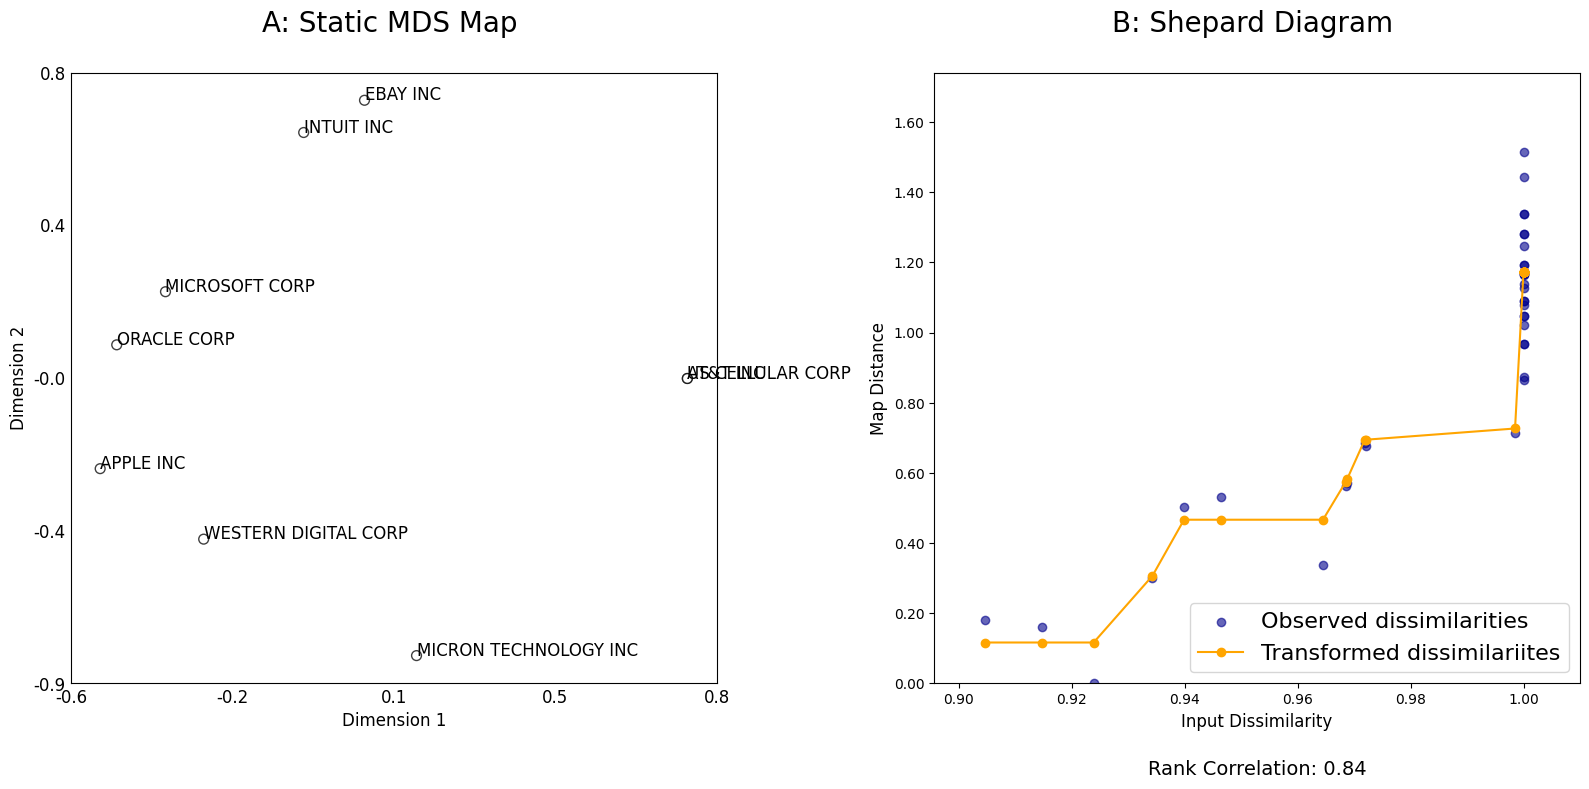

In [16]:
fig.tight_layout()
fig

In [17]:
print("Final Stress value: {0:.2f}".format(mds.cost_))

Final Stress value: 0.14


Save the Figure as Figure 1 of the Paper.

In [18]:
if os.path.exists(PATH_OUT):
  fig.savefig(os.path.join(PATH_OUT, 'Fig1_static_mapping.PNG'), dpi = 300)

## Dynamic Mapping via EvoMap

To illustrate Dynamic Mapping, we apply EvoMap, implemented for MDS, to the entire sequence of matrices.

First, we generate a sequence of starting configurations using Classical Scaling applied to the first period.

In [19]:
from evomap.mapping import CMDS
cmds_t = []
cmds = CMDS().fit_transform(D_t[0])
for t in range(n_periods):
    cmds_t.append(cmds)

Then, we apply EvoMap. Here, we set the alignment penalty (alpha) to .2, and add some smoothing by increasing p to 2:

In [21]:
from evomap.mapping import EvoMDS

evomds = EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t)

X_t = evomds.fit_transform(D_t)

In [22]:
print(len(X_t))
print(X_t[0].shape)

20
(9, 2)


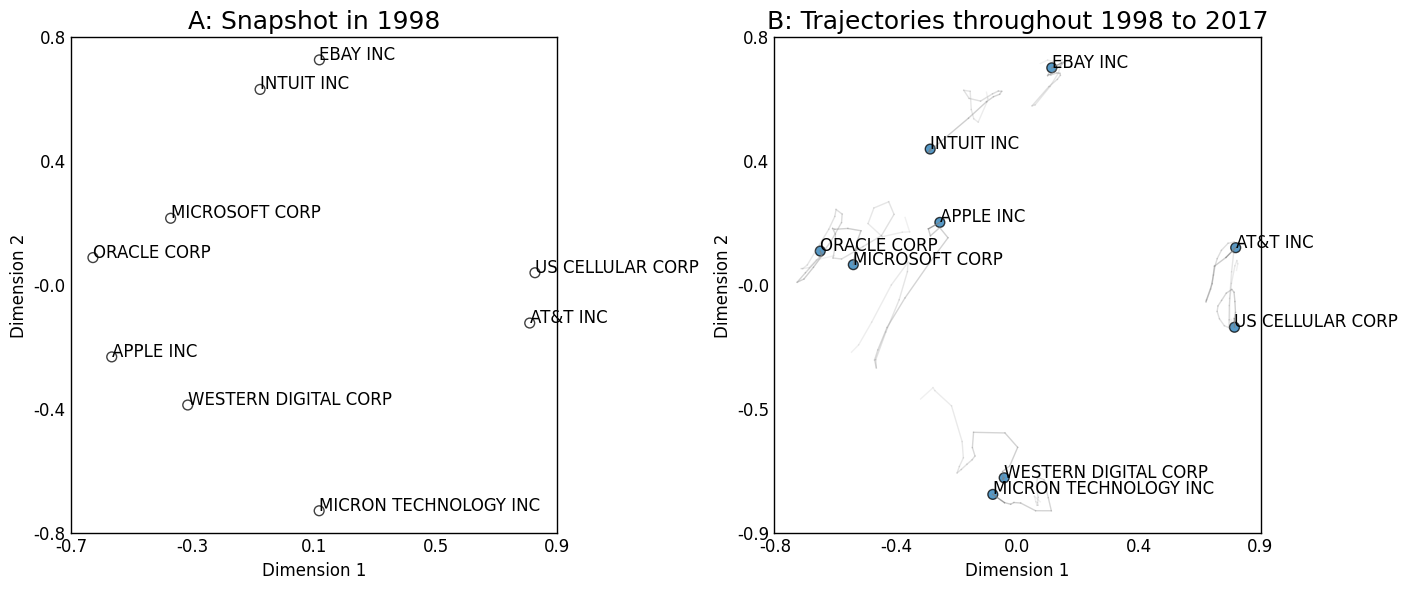

In [23]:
from evomap.printer import draw_dynamic_map

fig, ax = plt.subplots(1,2, figsize = (14, 6))

draw_map(X_t[0], label = labels, show_axes=True, show_box = True, ax = ax[0])
draw_dynamic_map(X_t,
                 label=labels,
                 show_axes=True,
                 show_last_positions_only=True,
                 show_arrows=True,
                 ax = ax[1])


ax[0].set_title('A: Snapshot in {}'.format(periods[0]), fontdict = title_fontdict)
ax[1].set_title('B: Trajectories throughout {0} to {1}'.format(periods[0], periods[-1]), fontdict = title_fontdict)

fig.tight_layout()
fig

In [24]:
print("The maps represent the evolving positions over {0} years between {1} and {2}".format(n_periods, periods[0], periods[-1]))

The maps represent the evolving positions over 20 years between 1998 and 2017


Save the Figure as Figure 2 in the paper.

In [25]:
if os.path.exists(PATH_OUT):
  fig.savefig(os.path.join(PATH_OUT, 'Fig2_dynamic_mapping.PNG'), dpi = 300)

# Part 2: Detailed Usage Example

This part goes through each step performed above in more detail.

## Basic Syntax

The basic usecase of EvoMap is creating dynamic maps of evolving relationship data, like the following:

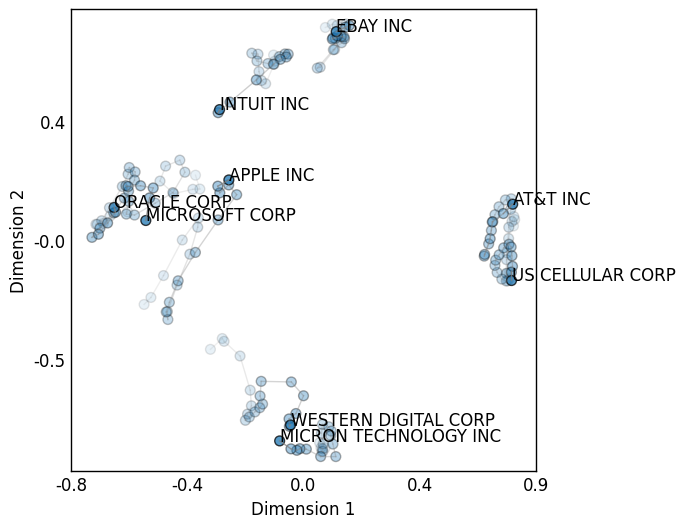

In [26]:
evomds = EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t)

X_t = evomds.fit_transform(D_t)

draw_dynamic_map(X_t,
                 label=labels,
                 show_arrows=True,
                 show_axes=True)

In [28]:
fig, ax = plt.subplots(figsize = (6,6))
draw_dynamic_map(X_t, label = labels, show_arrows= True, show_axes = True, ax = ax)
if os.path.exists(PATH_OUT):
  fig.savefig(os.path.join(PATH_OUT, 'Fig3_dynamic_map.PNG'), dpi = 300)

## Preprocessing

Before applying EvoMap, all input data needs to be formatted as a sequence of square matrices.

Here, our data is represented as an edgelist:

In [29]:
table_overview = pd.concat([data.head(), data.tail()], axis = 0)
table_overview = table_overview[['year', 'name1', 'name2', 'score', 'sic1', 'sic2', 'size1', 'size2']]
table_overview.size1 = table_overview.size1.round(2)
table_overview.size2 = table_overview.size2.round(2)
table_overview

,year,name1,name2,score,sic1,sic2,size1,size2
0,1998,APPLE INC,WESTERN DIGITAL CORP,0.0657,36,35,71.79,32.29
1,1998,APPLE INC,MICROSOFT CORP,0.0601,36,73,71.79,517.38
2,1998,APPLE INC,ORACLE CORP,0.0355,36,73,71.79,188.44
3,1998,AT&T INC,US CELLULAR CORP,0.0761,48,48,324.14,57.62
4,1998,EBAY INC,MICROSOFT CORP,0.0281,73,73,98.54,517.38
437,2017,ORACLE CORP,MICROSOFT CORP,0.1292,73,73,432.13,728.91
438,2017,ORACLE CORP,INTUIT INC,0.0231,73,73,432.13,187.30
439,2017,US CELLULAR CORP,AT&T INC,0.0184,48,48,56.56,488.57
440,2017,WESTERN DIGITAL CORP,APPLE INC,0.0321,35,36,161.40,888.85
441,2017,WESTERN DIGITAL CORP,MICRON TECHNOLOGY INC,0.0788,35,36,161.40,188.55


In [30]:
if os.path.exists(PATH_OUT):
  table_overview.to_excel(os.path.join(PATH_OUT, "table2-data-overview.xlsx"))

The basic syntax to use evomap consists of the following lines of code, which instantinates the method and fits it to the data. Note that the import statement is not necessary here, as we imported the class before, but only included for completeness of this minimal example.

In [31]:
from evomap.mapping import EvoMDS

evomds = EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t)

X_t = evomds.fit_transform(D_t)

The output is a list of arrays shape (n_samples, n_dims)

In [32]:
print(type(X_t))

<class 'list'>


In [33]:
print(len(X_t))

20


In [34]:
print(X_t[0].round(2))

[[-0.53 -0.26]
 [ 0.77 -0.15]
 [ 0.11  0.73]
 [-0.07  0.63]
 [ 0.11 -0.77]
 [-0.35  0.2 ]
 [-0.59  0.07]
 [ 0.78  0.02]
 [-0.3  -0.42]]


## Hyperparameters

A crucial task when running EvoMap is to find suitable values for its hyperparameters.

Here, we illustrate the effect that varying values of these hyperparamters have on EvoMap's output:

Varying levels of alpha:

In [35]:
X_t_low_alpha = EvoMDS(alpha = 0.01, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_mid_alpha = EvoMDS(alpha = 0.2, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_high_alpha = EvoMDS(alpha = 1.5, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)

Varying levels of p:

In [36]:
X_t_p1 = EvoMDS(alpha = .2, p = 1, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_p2 = EvoMDS(alpha = .2, p = 2, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_p3 = EvoMDS(alpha = .2, p = 3, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)

Plot results:

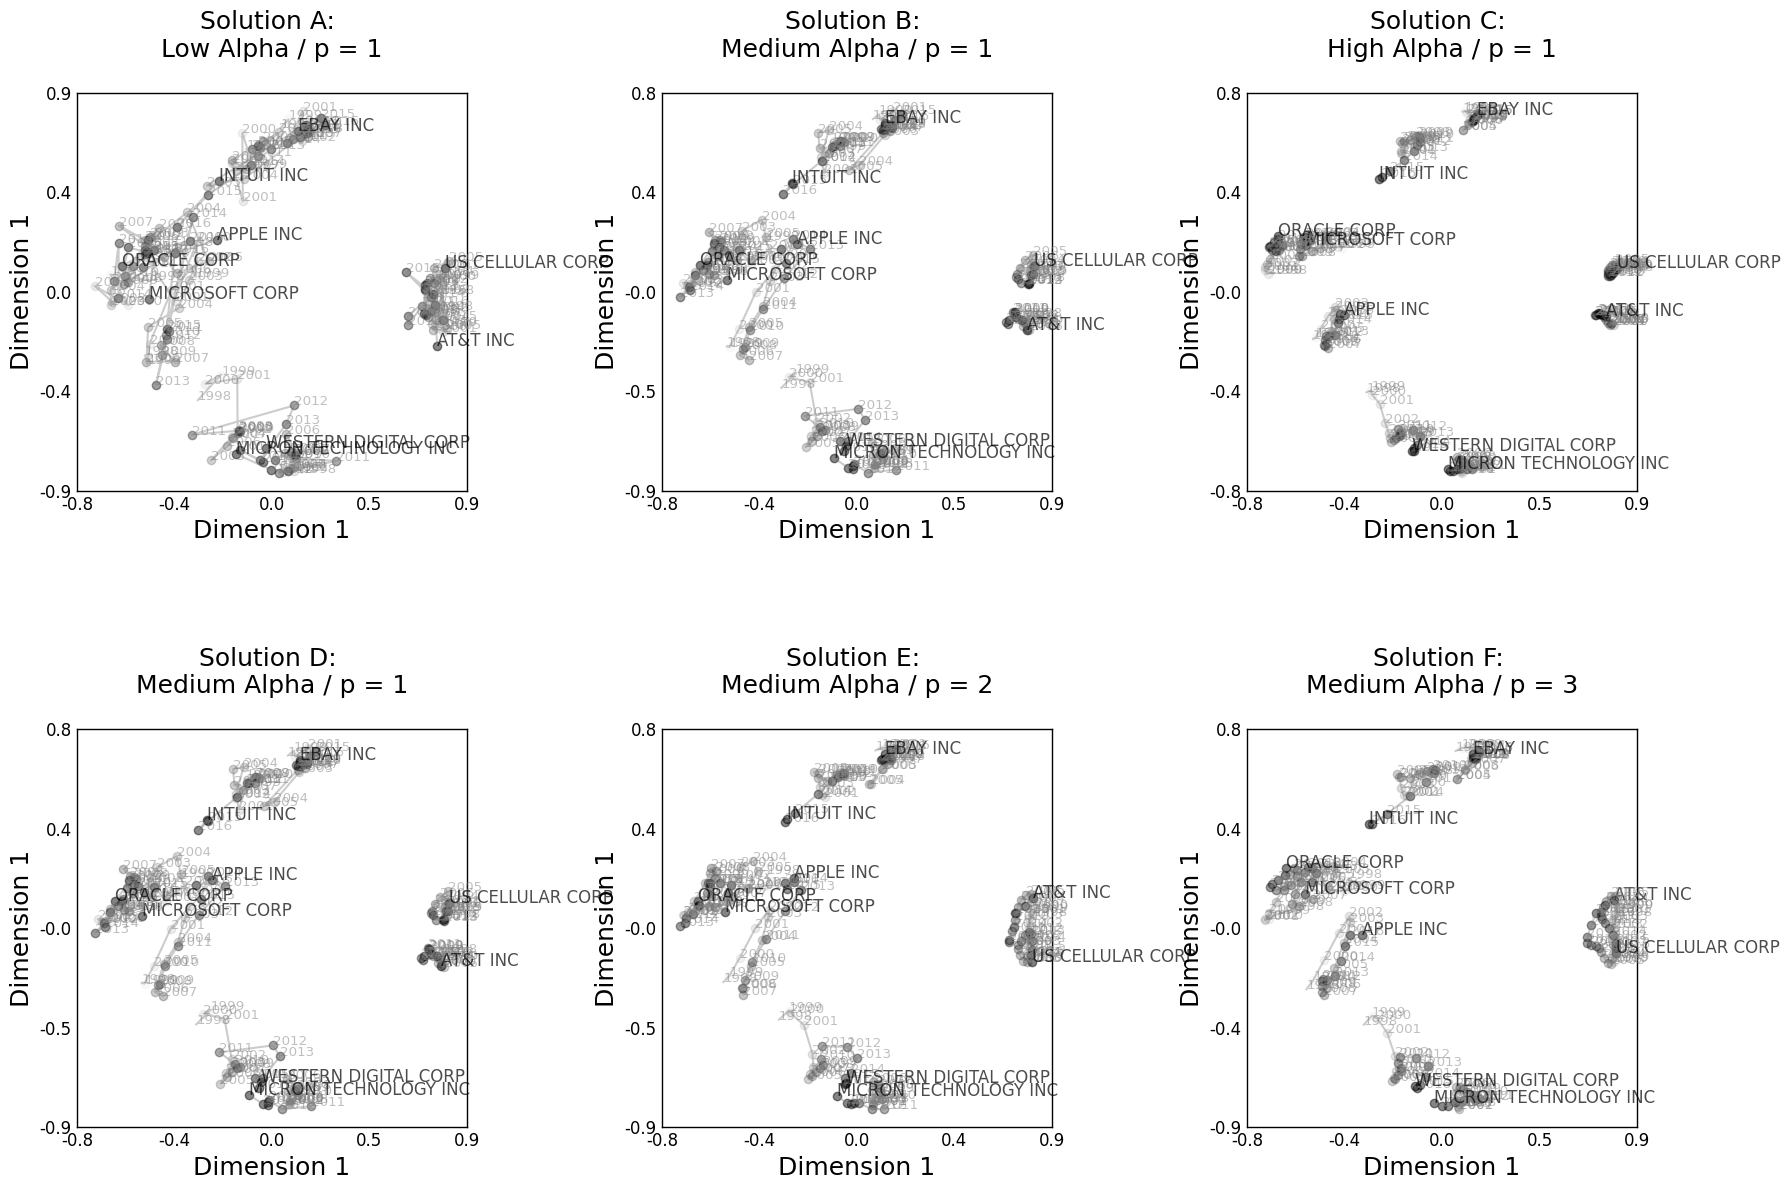

In [37]:
from evomap.printer import draw_trajectories
fig, ax = plt.subplots(2,3,figsize = (18,12))

draw_trajectories(X_t_low_alpha, show_axes= True, labels = labels, period_labels= periods, ax = ax[0,0])
draw_trajectories(X_t_mid_alpha, labels = labels, period_labels = periods, show_axes=True, ax = ax[0,1])
draw_trajectories(X_t_high_alpha, labels = labels, period_labels = periods, show_axes = True, ax = ax[0,2])

draw_trajectories(X_t_p1, show_axes= True, labels = labels, period_labels= periods, ax = ax[1,0])
draw_trajectories(X_t_p2, labels = labels, period_labels = periods, show_axes=True, ax = ax[1,1])
draw_trajectories(X_t_p3, labels = labels, period_labels = periods, show_axes = True, ax = ax[1,2])

ax[0,0].set_title('Solution A: \nLow Alpha / p = 1\n', fontdict = title_fontdict)
ax[0,1].set_title('Solution B: \nMedium Alpha / p = 1\n', fontdict = title_fontdict)
ax[0,2].set_title('Solution C: \nHigh Alpha / p = 1\n', fontdict = title_fontdict)
ax[1,0].set_title('Solution D: \nMedium Alpha / p = 1\n', fontdict = title_fontdict)
ax[1,1].set_title('Solution E: \nMedium Alpha / p = 2\n', fontdict = title_fontdict)
ax[1,2].set_title('Solution F: \nMedium Alpha / p = 3\n', fontdict = title_fontdict)

ax[0,0].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[0,1].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[0,2].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[1,0].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[1,1].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[1,2].set_xlabel('Dimension 1', fontdict = title_fontdict)

ax[0,0].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[0,1].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[0,2].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[1,0].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[1,1].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[1,2].set_ylabel('Dimension 1', fontdict = title_fontdict)
fig.tight_layout()
fig.subplots_adjust(
    hspace= .6,
    wspace = .5
)
if os.path.exists(PATH_OUT):
  fig.savefig(os.path.join(PATH_OUT, 'Fig5_hyperparamters.PNG'), dpi = 300)

fig

## Convergence Diagnostics

To obtain more details on how well the optimization converges, the user can change the 'verbose' parameter:

In [38]:
EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t,
    verbose = 1).fit(D_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 535: gradient norm vanished. Final cost: 3.87


In [39]:
EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t,
    n_iter_check = 50,
    verbose = 2).fit(D_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 3.90 -- Gradient Norm: 0.0176
[EvoMDS] Iteration 100 -- Cost: 3.88 -- Gradient Norm: 0.0089
[EvoMDS] Iteration 150 -- Cost: 3.88 -- Gradient Norm: 0.0100
[EvoMDS] Iteration 200 -- Cost: 3.88 -- Gradient Norm: 0.0059
[EvoMDS] Iteration 250 -- Cost: 3.88 -- Gradient Norm: 0.0052
[EvoMDS] Iteration 300 -- Cost: 3.88 -- Gradient Norm: 0.0045
[EvoMDS] Iteration 350 -- Cost: 3.88 -- Gradient Norm: 0.0024
[EvoMDS] Iteration 400 -- Cost: 3.87 -- Gradient Norm: 0.0121
[EvoMDS] Iteration 450 -- Cost: 3.87 -- Gradient Norm: 0.0037
[EvoMDS] Iteration 500 -- Cost: 3.87 -- Gradient Norm: 0.0046
[EvoMDS] Iteration 535: gradient norm vanished. Final cost: 3.87


## Exploration

Once EvoMap ran, the user can explore its output in either static or dynamic maps. The two main functions are:
- draw_map
- draw_dynamic_map

#### Static Exploration via Draw Map

Use static maps to compare snapshots

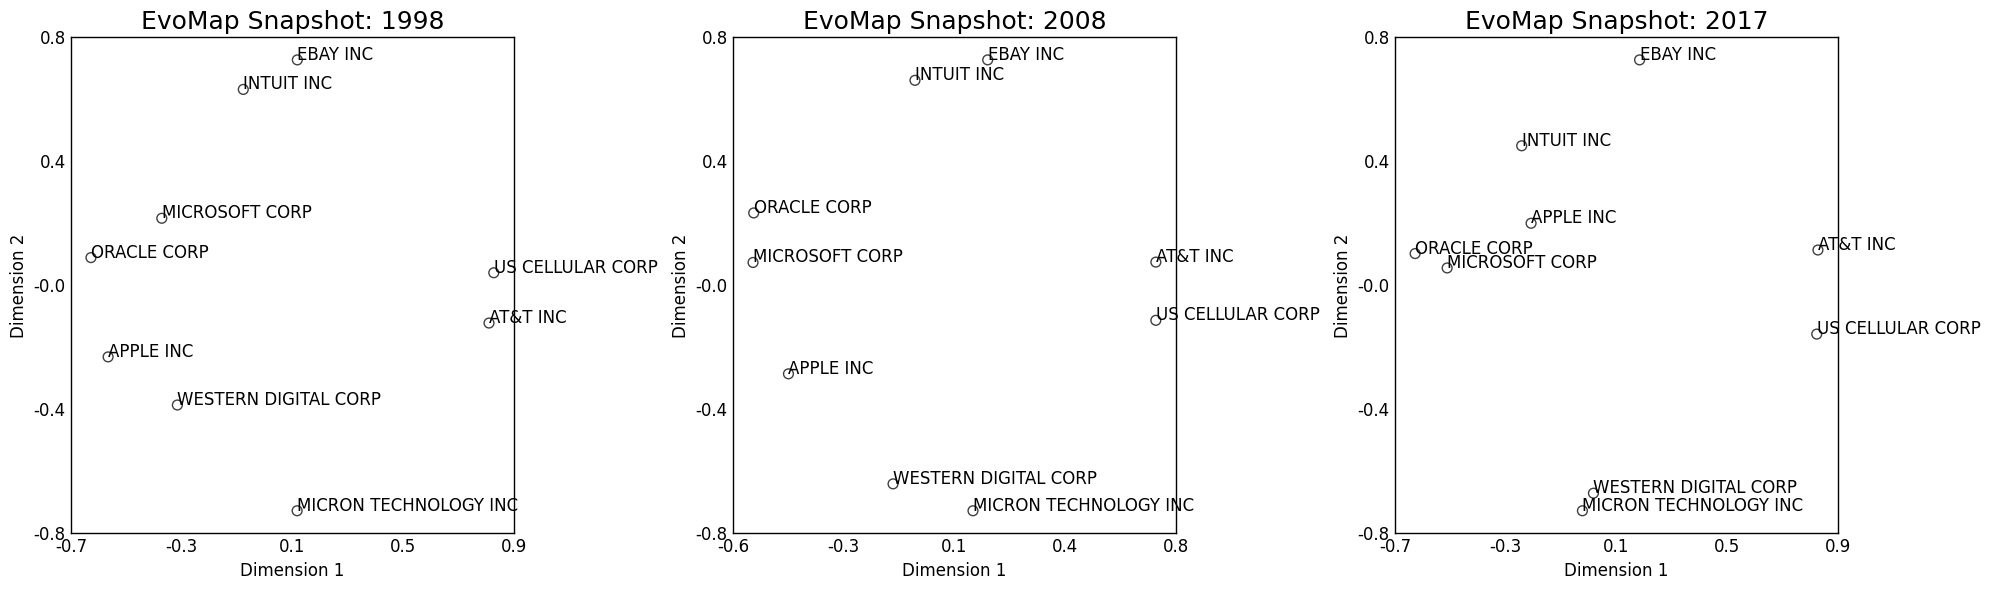

In [40]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
draw_map(X_t[0], label = labels, ax = ax[0])
draw_map(X_t[10], label = labels, ax = ax[1])
draw_map(X_t[19], label = labels, ax = ax[2])

ax[0].set_title('EvoMap Snapshot: {0}'.format(periods[0]), **title_fontdict)
ax[1].set_title('EvoMap Snapshot: {0}'.format(periods[10]), **title_fontdict)
ax[2].set_title('EvoMap Snapshot: {0}'.format(periods[19]), **title_fontdict)

fig.tight_layout()
fig

In [41]:
if os.path.exists(PATH_OUT):
  fig.savefig(os.path.join(PATH_OUT, 'Fig6_static_snapshots.PNG'), dpi = 300)

Also, we can augment the maps by linking variables in our data to visual characteristics.

For instance, we can color each point based on the firm's SIC code.

In [42]:
sic_codes = []
for firm in labels:
    sic_codes.append(data.query('name1 == @firm').sic1.unique()[0])
print(sic_codes)

[36, 48, 73, 73, 36, 73, 73, 48, 35]


Or, we can adjust the size of each point proportional to the firm's market value:

In [43]:
sizes = []
for firm in labels:
    sizes.append(data.query('name1 == @firm').size1.unique()[0].round(2))
print(sizes)

[71.79, 324.14, 98.54, 54.32, 69.69, 517.38, 188.44, 57.62, 32.29]


Such variables can be added to the map via the 'c' and 'size' arguments:

<ipython-input-44-21f79787bcc9>:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


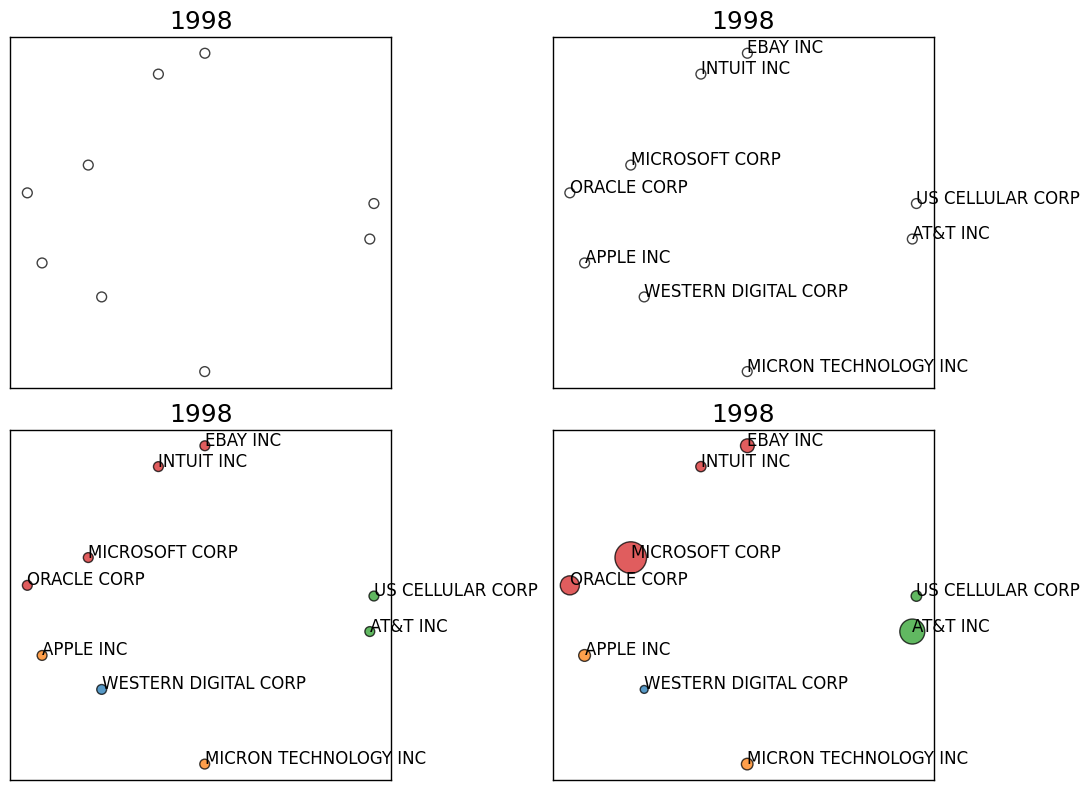

In [44]:
sic = data.sic1

fig, ax = plt.subplots(2,2,figsize = (11,8), layout = 'constrained')
draw_map(X_t[0], show_axes = False, title = periods[0], ax = ax[0,0])
draw_map(X_t[0], label = labels, show_axes = False, title = periods[0], ax = ax[0,1])
draw_map(X_t[0], label = labels, show_axes = False, color = sic_codes, show_legend = False, title = periods[0], ax = ax[1,0])
draw_map(X_t[0], label = labels, color = sic_codes, size = sizes, show_axes=False,
title = periods[0], ax = ax[1,1])
fig.tight_layout()

#ax[1,0].legend(title = 'SIC Code', loc = 'lower right', bbox_to_anchor = (1.22, 0.0))

if os.path.exists(PATH_OUT):
  fig.savefig(os.path.join(PATH_OUT, 'Fig7_draw_map_illustrations.PNG'), dpi = 300)

fig

## Drawing Dynamic Maps

Beyond individual snapshots, evomap allows to create dynamic maps, overlaying multiple
snapshots to illustrate changes over time. This is accomplished with draw_dynamic_map()
or draw_trajectories().

### Dynamic Map

Before we draw the map, we store the additional variables linked to color and size:

In [45]:
sic_codes_t = []
sizes_t = []
for t in range(n_periods):
    data_this = data.query('year == @periods[@t]')
    sic_this = []
    for firm in labels:
        sic_this.append(data_this.query('name1 == @firm').sic1.unique()[0])

    sic_codes_t.append(np.array(sic_this))

    sizes_this = []
    for firm in labels:
        sizes_this.append(data_this.query('name1 == @firm').size1.unique()[0])

    sizes_t.append(np.array(sizes_this))


We then draw the map, using these variabels as additional aesthetics:

In [46]:
fig, ax = plt.subplots(1,2, figsize = (16,7))

from evomap.printer import draw_dynamic_map
draw_dynamic_map(X_t,
                 label = labels,
                 color_t = sic_codes_t,
                 size_t = sizes_t,
                 show_arrows = True,
                 show_axes = True,
                 ax = ax[0])

### Draw Trajectories

Alternatively, draw_trajectories focuses solely on all objects' movement paths:

In [47]:
from evomap.printer import draw_trajectories
draw_trajectories(X_t,
                  labels = labels,
                  period_labels = periods,
                  show_axes=True,
                  ax = ax[1])

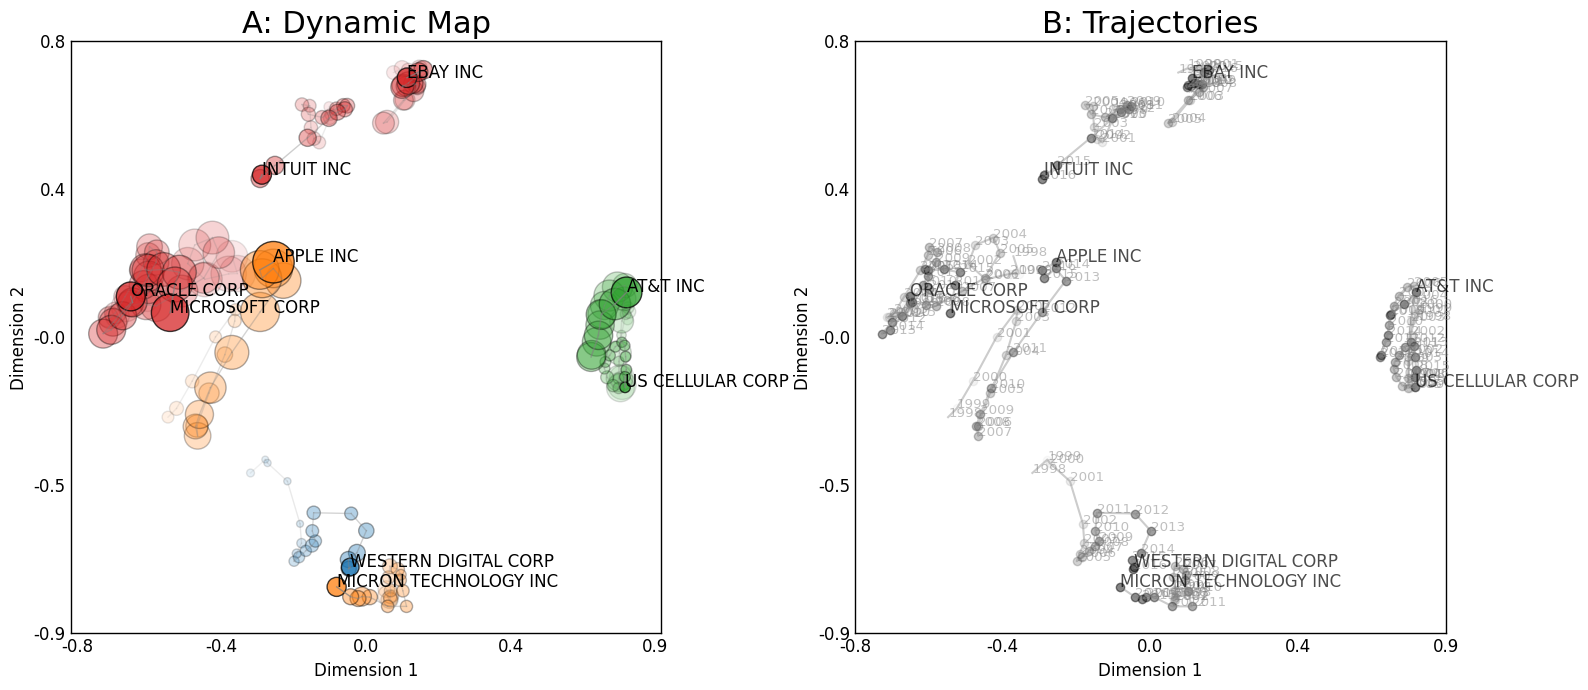

In [48]:
ax[0].set_title('A: Dynamic Map')
ax[1].set_title('B: Trajectories')

fig.tight_layout()
if os.path.exists(PATH_OUT):
  fig.savefig(os.path.join(PATH_OUT, 'Fig8_dynamic_map_and_trajectories.PNG'), dpi = 300)
fig

## Evaluation

While visual exploration allows to explore the mapping results, it is essential to evalute how
well they represent the underlying data. This can be achieved through:

### Cost Function Values

In [49]:
cmds_indep = []
for t in range(n_periods):
  cmds_indep.append(CMDS().fit_transform(D_t[t]))

evomds_indep = EvoMDS(
    alpha = 0,
    init = cmds_indep,
    mds_type= 'ordinal').fit(D_t)

print(evomds_indep.cost_static_avg_.round(4))
print(evomds.cost_static_avg_.round(4))

0.1875
0.1911


### Evaluation Metrics

In [50]:
from evomap.metrics import *
misalign_score(X_t).round(4)

0.0468

In [51]:
persistence_score(X_t).round(4)

0.6484

For comparison, we also compute these metrics for two additional solutions:
- Independent Mapping
- Independent Mapping, aligned via Procrustes Analysis

In [52]:
from evomap.transform import align_maps
X_t_indep = EvoMDS(alpha = 0, mds_type = 'ordinal', init = cmds_indep).fit_transform(D_t)
X_t_indep_aligned = align_maps(X_t_indep, X_t[0])

Overview of all results:

In [53]:
from evomap.metrics import *

misalign_score_t = []
persistence_score_t = []

for i, X in enumerate([X_t, X_t_indep, X_t_indep_aligned]):
    misalign_score_t.append(misalign_score(X))
    persistence_score_t.append(persistence_score(X))

metrics = pd.DataFrame({'misalign_score': misalign_score_t,
                        'persistence_score': persistence_score_t},
                          index = ['EvoMDS', 'Independent MDS', 'Independent MDS + Alignment'])

metrics['average_stress'] = [evomds.cost_static_avg_, evomds_indep.cost_static_avg_, evomds_indep.cost_static_avg_]

# sort metrics such that the order is Independent MDS, Independent MDS + Alignment, EvoMDS
metrics = metrics.reindex(['Independent MDS', 'Independent MDS + Alignment', 'EvoMDS'])
metrics.round(4)

,misalign_score,persistence_score,average_stress
Independent MDS,0.9737,-0.5589,0.1875
Independent MDS + Alignment,0.3074,-0.2718,0.1875
EvoMDS,0.0468,0.6484,0.1911


In [54]:
if os.path.exists(PATH_OUT):
  metrics.round(4).to_excel(os.path.join(PATH_OUT, 'sect4_metrics.xlsx'))

## Hyperparameter Tuning

To facilitate finding good hyperparameters, evomap allows the user to conduct a grid search over a
range of hyperparameter values.

### Using the Grid Search

First, define the parameter space across which the grid search shall be completed

In [55]:
param_grid = {
    'alpha': np.linspace(0, 1.5, 15),
    'p': [1,2]}

Next, define the metrics on which each parameter combination is to be evaluated

In [56]:
from evomap.metrics import misalign_score, persistence_score, avg_hitrate_score

metrics = [misalign_score, persistence_score, avg_hitrate_score]
metric_labels = ['Misalignment', 'Persistence', 'Hitrate']

Then, perform the grid search:

In [57]:
model = EvoMDS(init = cmds_t, mds_type = 'ordinal')

df_grid_results = model.grid_search(
    Xs = D_t,
    param_grid = param_grid,
    eval_functions =  metrics,
    eval_labels = metric_labels,
    kwargs = {"input_format" : 'dissimilarity'})

[EvoMDS] Diverging gradient norm at iteration 211
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 99
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 69
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 54
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 46
[EvoMDS] Adjusting step sizes..


View the results:

In [58]:
df_grid_results.head()

,p,cost_static_avg,Misalignment,Persistence,Hitrate
alpha,,,,,
0.000000,1,0.184808,0.145132,-0.471110,0.9
0.000000,2,0.184808,0.145132,-0.471110,0.9
0.107143,1,0.184993,0.073288,0.014034,0.9
0.107143,2,0.189304,0.052314,0.501950,0.9
0.214286,1,0.187064,0.057209,0.240635,0.9


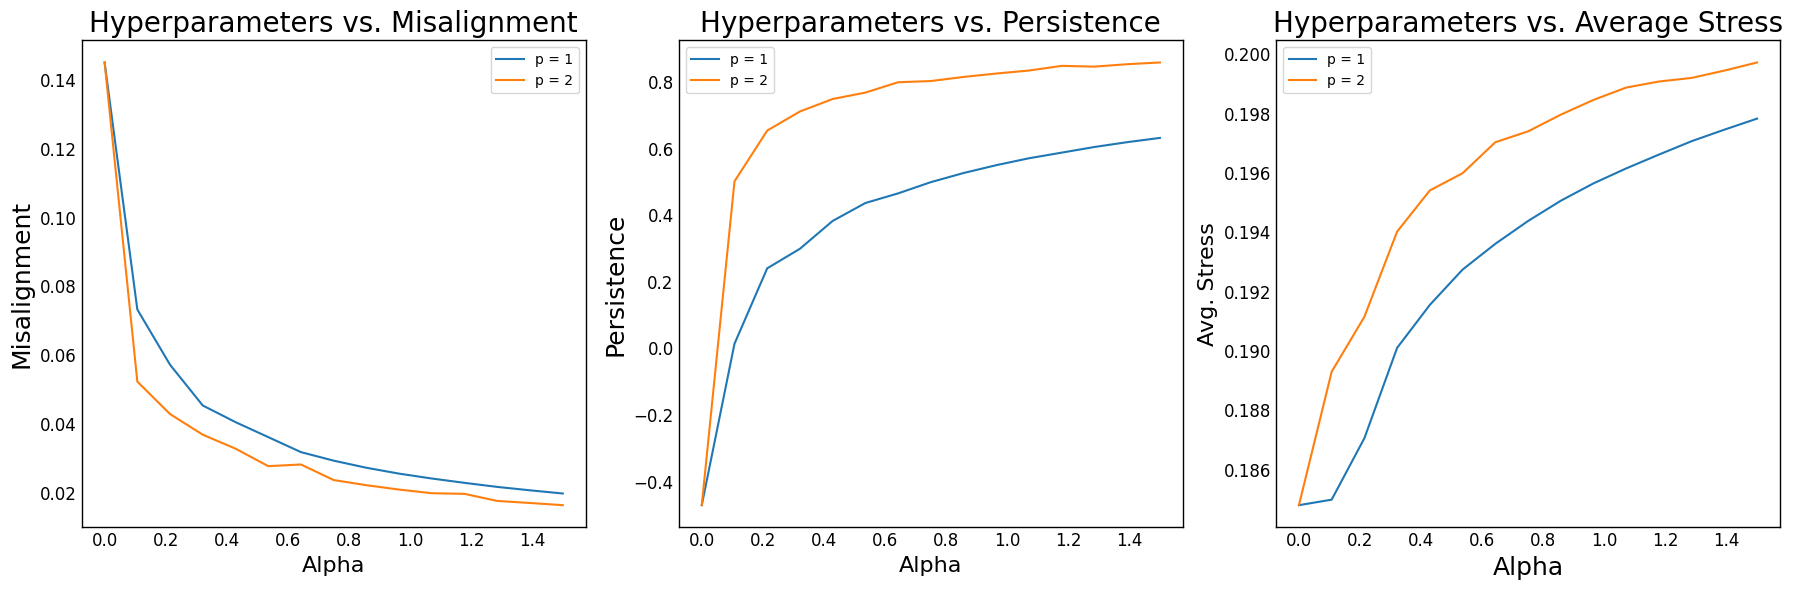

In [59]:
fig, ax = plt.subplots(1,3, figsize = (18, 6))
df_grid_results.groupby('p')['Misalignment'].plot(legend = True, ax = ax[0])
df_grid_results.groupby('p')['Persistence'].plot(legend = True, ax = ax[1])
df_grid_results.groupby('p')['cost_static_avg'].plot(legend = True, ax = ax[2])

ax[0].set_title('Hyperparameters vs. Misalignment', fontdict = title_fontdict_large)
ax[0].set_xlabel('Alpha', fontdict = label_fontdict)
ax[0].set_ylabel('Misalignment', fontdict = label_fontdict_large)
ax[0].legend(labels = ['p = 1', 'p = 2'])
ax[1].set_title('Hyperparameters vs. Persistence', fontdict = title_fontdict_large)
ax[1].set_xlabel('Alpha', fontdict = label_fontdict)
ax[1].set_ylabel('Persistence', fontdict = label_fontdict_large)
ax[1].legend(labels = ['p = 1', 'p = 2'])
ax[2].set_title('Hyperparameters vs. Average Stress', fontdict = title_fontdict_large)
ax[2].set_xlabel('Alpha', fontdict = label_fontdict_large)
ax[2].set_ylabel('Avg. Stress', fontdict = label_fontdict)
ax[2].legend(labels = ['p = 1', 'p = 2'])

fig.tight_layout()
if os.path.exists(PATH_OUT):
  fig.savefig(os.path.join(PATH_OUT, 'Fig9_grid_search.PNG'), dpi = 300)

## Unbalanced Data

Dynamic mapping often encounters scenarios where the set of objects changes over time, such
as firms entering or exiting a market. The evomap package accommodates such unbalanced
data through inclusion vectors.

First, we load an unbalanced sample for this illustration:

In [60]:
data_unbalanced = load_tnic_sample_tech(unbalanced = True)
data_unbalanced.groupby('name1').agg({'year': 'nunique'})

,year
name1,
APPLE INC,20
AT&T INC,20
EBAY INC,20
INTUIT INC,20
MICRON TECHNOLOGY INC,20
MICROSOFT CORP,20
NETFLIX INC,16
ORACLE CORP,20
US CELLULAR CORP,20


Then, transform the edgelist into a sequence of square matrices:

In [61]:
from evomap.preprocessing import edgelist2matrices
S_t, labels = edgelist2matrices(
    data_unbalanced,
    score_var='score',
    id_var_i='name1',
    id_var_j='name2',
    time_var = 'year')

As the sample was unbalanced, the resultant matrices have unequal shape:

In [62]:
print(S_t[0].shape)
print(S_t[-1].shape)

(9, 9)
(10, 10)


Thus, we next expand the matrices to a common shape:

In [63]:
from evomap.preprocessing import expand_matrices
S_t, inc_t, labels = expand_matrices(S_t, labels)

In [64]:
print(S_t[0].shape)

(10, 10)


The inclusion vectors indicate which objects will be considered by the mapping algorithm in each period:

In [65]:
print(inc_t[0])

[1 1 1 1 1 1 1 1 1 0]


In [66]:
inc_t[-1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Once the matrices are prepared, we can continue to transform them into dissimilarities as before:

In [67]:
D_t = []
for S in S_t:
    D = sim2diss(S, transformation='mirror')
    D_t.append(D)

We define starting positions:

In [68]:
inits_ts = [np.concatenate([cmds, np.array([[0,0]])], axis = 0) for cmds in cmds_t]

And run EvoMap, passing the inclusion vectors to fit_transform:

In [69]:
from evomap.mapping import EvoMDS
X_t = EvoMDS(alpha = 0.75,
             p = 2,
             mds_type = 'ordinal',
             init = inits_ts,
             verbose=2).fit_transform(D_t, inclusions = inc_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 4.85 -- Gradient Norm: 0.0694
[EvoMDS] Iteration 100 -- Cost: 4.61 -- Gradient Norm: 0.0285
[EvoMDS] Iteration 150 -- Cost: 4.54 -- Gradient Norm: 0.0220
[EvoMDS] Iteration 200 -- Cost: 4.49 -- Gradient Norm: 0.0157
[EvoMDS] Iteration 250 -- Cost: 4.47 -- Gradient Norm: 0.0107
[EvoMDS] Iteration 300 -- Cost: 4.46 -- Gradient Norm: 0.0072
[EvoMDS] Iteration 350 -- Cost: 4.45 -- Gradient Norm: 0.0050
[EvoMDS] Iteration 400 -- Cost: 4.44 -- Gradient Norm: 0.0070
[EvoMDS] Iteration 450 -- Cost: 4.44 -- Gradient Norm: 0.0053
[EvoMDS] Iteration 500 -- Cost: 4.43 -- Gradient Norm: 0.0050
[EvoMDS] Iteration 550 -- Cost: 4.43 -- Gradient Norm: 0.0039
[EvoMDS] Iteration 600 -- Cost: 4.43 -- Gradient Norm: 0.0028
[EvoMDS] Iteration 650 -- Cost: 4.42 -- Gradient Norm: 0.0031
[EvoMDS] Iteration 700 -- Cost: 4.42 -- Gradient Norm: 0.0022
[EvoMDS] Iteration 750 -- Cost: 4.42 -- Gradient Norm: 0.0024
[EvoMDS

Finally, we visualize the results in two snapshots.

The left snapshot does not include Netflix, which only entered the sample during the observation period, while the right
snapshot includes the newly entered firm.

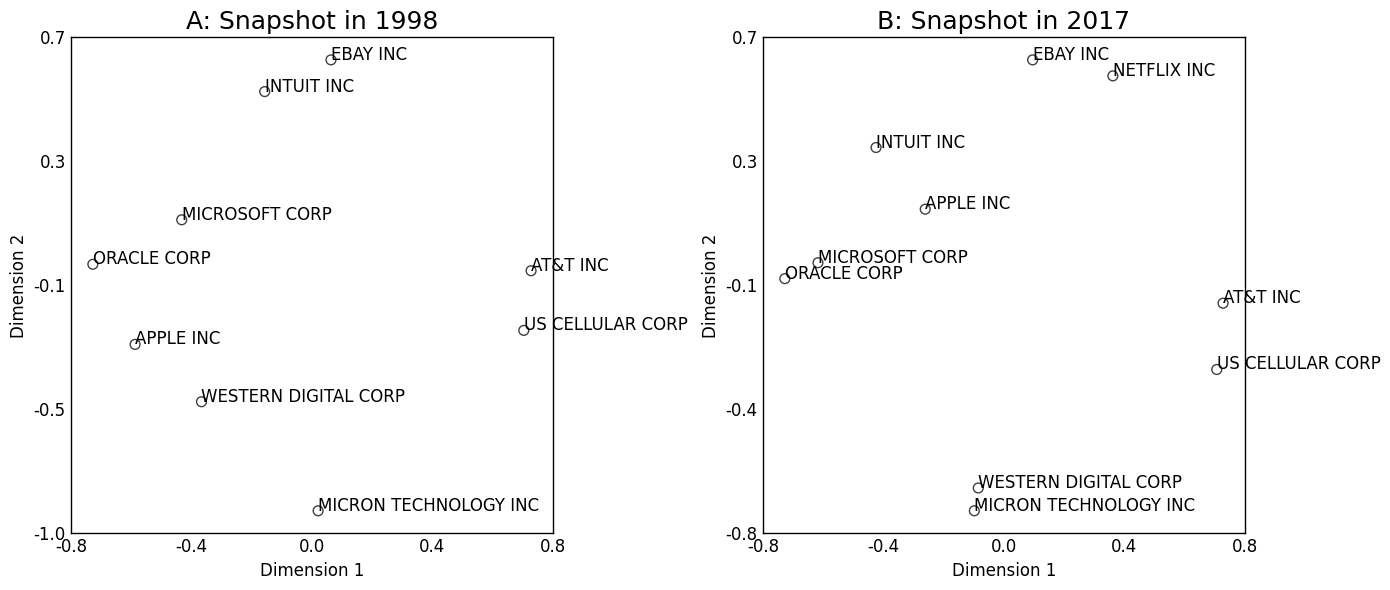

In [70]:
from matplotlib import pyplot as plt
from evomap.printer import draw_map
fig, ax = plt.subplots(1,2,figsize=(14, 6))
draw_map(X_t[0],
         inclusions = inc_t[0],
         label = labels,
         ax = ax[0],
         show_axes=True,
         title = 'A: Snapshot in {0}'.format(periods[0]))
draw_map(X_t[-1],
         inclusions = inc_t[-1],
         label = labels,
         ax = ax[1],
         show_axes = True,
         title = 'B: Snapshot in {0}'.format(periods[-1]))
fig.tight_layout()
if os.path.exists(PATH_OUT):
  fig.savefig(os.path.join(PATH_OUT, 'Fig10_unbalanced.PNG'), dpi = 300)
fig

# Further Ressources

For further usage examples, based on a larger dataset, see https://evomap.readthedocs.io/en/latest/dynamic%20mapping.html